# Objectives

- Understand decoder-only generative AI models
- Introduction to the world of LLMs
- Prompt Engineering for NLP tasks

# Setup

In [1]:
! pip install -q datasets==2.20.0 \
                 evaluate==0.4.2 \
                 bert-score==0.3.13

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dash 2.17.0 requires dash-core-components==2.0.0, which is not installed.
dash 2.17.0 requires dash-html-components==2.0.0, which is not installed.
dash 2.17.0 requires dash-table==5.0.0, which is not installed.
autogluon-core 0.8.3 requires pandas<1.6,>=1.4.1, but you have pandas 2.1.4 which is incompatible.
autogluon-core 0.8.3 requires scikit-learn<1.4.1,>=1.1, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-multimodal 0.8.3 requires pandas<1.6,>=1.4.1, but you have pandas 2.1.4 which is incompatible.
autogluon-multimodal 0.8.3 requires pytorch-lightning<1.10.0,>=1.9.0, but you have pytorch-lightning 2.0.9 which is incompatible.
autogluon-multimodal 0.8.3 requires scikit-learn<1.4.1,>=1.1, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-multimodal 0.8.3 requires torch<1.14,>=1.

In [2]:
import math
import torch

import numpy as np
import pandas as pd

import tensorflow as tf

from transformers import (
    AutoTokenizer, AutoModelForCausalLM
)

from huggingface_hub import InferenceClient
from datasets import load_dataset
from evaluate import load

2024-08-26 13:28:53.044769: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# The Original Transformer

In the previous session, we dove into encoder-only models based on the left block of the original transformer architecture (figure below). Let us now turn our attention to the right side of this architecture that gave rise to the generative AI revolution.

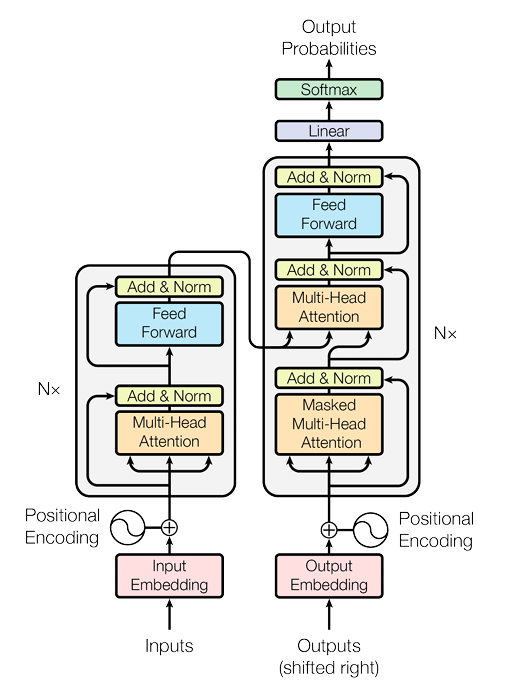

(Source: https://arxiv.org/pdf/1706.03762)

# Masked Self-Attention

A key portion of the decoder-side of the original transformer architecture that makes it different from the encoder side is masked multi-head attention. Let us go back to our implementation of single-query attention to understand why a mask is needed and how it helps in training the decoder-side of this architecture.

In [3]:
input_sequences = [
    "This is an awesome movie",
    "Great action set pieces overall"
]

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=25,
    output_sequence_length=5
)

text_ds = tf.data.Dataset.from_tensor_slices(input_sequences)
vectorizer.adapt(text_ds)

print(f"Vocabulary size: {len(vectorizer.get_vocabulary())}")

embedding_layer = tf.keras.layers.Embedding(
    len(vectorizer.get_vocabulary()),
    100,
    trainable=True
)

x_train = vectorizer(np.array([[s] for s in input_sequences])).numpy()

embedded_sequences = embedding_layer(x_train)

Vocabulary size: 12


In [4]:
x_train.shape, embedded_sequences.shape

((2, 5), TensorShape([2, 5, 100]))

In [9]:
class SingleQueryAttention(tf.Module):
    """Contextualize single input embedding by attending over context embeddings."""

    def __init__(self, d_x: int, d_z: int, d_attn: int, d_out: int, do_init: bool = True):
        super().__init__()  # Properly initialize the tf.Module without arguments
        self.d_x = d_x
        self.d_z = d_z
        self.d_attn = d_attn
        self.d_out = d_out
        self.do_init = do_init

        self.scale = 1 / math.sqrt(d_attn)

        # Define the weight tensors
        self.w_q = tf.Variable(tf.random.uniform([d_x, d_attn]), trainable=True)
        self.w_k = tf.Variable(tf.random.uniform([d_z, d_attn]), trainable=True)
        self.w_v = tf.Variable(tf.random.uniform([d_z, d_out]), trainable=True)

        # Define the bias tensors
        self.b_q = tf.Variable(tf.zeros([d_attn]), trainable=True)
        self.b_k = tf.Variable(tf.zeros([d_attn]), trainable=True)
        self.b_v = tf.Variable(tf.zeros([d_out]), trainable=True)

        if self.do_init:
            self.init_weights()

    def init_weights(self):
        initializer = tf.keras.initializers.GlorotNormal(seed=42)
        self.w_q.assign(initializer([self.d_x, self.d_attn]))
        self.w_k.assign(initializer([self.d_z, self.d_attn]))
        self.w_v.assign(initializer([self.d_z, self.d_out]))

        self.b_q.assign(tf.zeros([self.d_attn]))
        self.b_k.assign(tf.zeros([self.d_attn]))
        self.b_v.assign(tf.zeros([self.d_out]))

    def __call__(self, x1: tf.Tensor, z: tf.Tensor, mask: tf.Tensor):
        # Ensure x1 is 2D [1, d_x] before multiplication
        q = tf.matmul(tf.expand_dims(x1, axis=0), self.w_q) + self.b_q
        k = tf.matmul(z, self.w_k) + self.b_k
        v = tf.matmul(z, self.w_v) + self.b_v

        # Now q is [1, d_attn] and k is [l_z, d_attn]
        score = tf.matmul(q, k, transpose_b=True) * self.scale
        score = tf.where(tf.cast(mask, tf.bool), score, tf.fill(score.shape, -float("Inf")))
        attention = tf.nn.softmax(score, axis=-1)

        # Now, attention is [1, l_z] and v is [l_z, d_out]
        vtilde = tf.matmul(attention, v)

        return {
            "q": q,
            "k": k,
            "v": v,
            "score": score,
            "attention": attention,
            "vtilde": tf.squeeze(vtilde),  # Removing the added dimension
        }

So far there is no difference from the encoder-style attention. However, when we are training to predict the next token given an input token, we cannot expose the future keys in the sequence to the query. With the original $\mathbf{Q} \mathnf{K}^T$ computation all tokens are contextualized with the rest of the tokens irrespective of whether they appear before or after the query. To control this, we need to place a mask on top of the $\mathbf{Q} \mathnf{K}^T$ so that future tokens are masked. This is what the line `score = tf.where(tf.cast(mask, tf.bool), score, tf.fill(score.shape, -float("Inf")))` accomplishes. This code snipper means that, given a mask, whenever the value at the mask entry is 1, the attention score is retained but when the mask entry is 0, we replace the attention score by $-\infty$. This ensures that post softmax, the attention scores of the masked tokens (i.e., flag 0 words) get a 0 attention score effectively blocking them out from the attention computation.

In [10]:
d_x, d_z, d_attn, d_out = 100, 100, 200, 400
mask = tf.constant([1, 0, 0, 0], dtype=tf.int32) # cannot see the future

In [11]:
sqa = SingleQueryAttention(d_x, d_z, d_attn, d_out)

In [12]:
embedded_sequences[0][1].shape # single query from the first sequence - 'is'

TensorShape([100])

In [13]:
embedded_sequences[0][1:].shape # rest of the tokens are the context

TensorShape([4, 100])

Masked self-attention is where the query can focus only on the past and not the future. The computation is still parallel due to the clever masking.

In [14]:
contextualized_token_is = sqa(
    embedded_sequences[0][1],
    embedded_sequences[0][1:],
    mask
)

In [15]:
contextualized_token_is['attention']

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[1., 0., 0., 0.]], dtype=float32)>

Notice how the attention score of 3 future tokens is zeroed out due to the mask (see figure below).

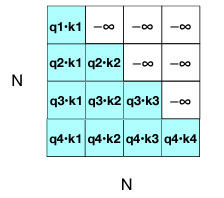

# Decoder-only Models

All LLMs are implementations of decoder-only architectures. Let us take a look at two of them - GPT2 and Mistral 7b.

In [11]:
gpt2_tokenizer = AutoTokenizer.from_pretrained(
    'gpt2',
    max_length=9,
    padding_side="left"
)

/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [12]:
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

In [13]:
input_sequences = [
    "This is an awesome movie",
    "Great action set pieces overall"
]

In [14]:
inputs = gpt2_tokenizer(
    input_sequences,
    max_length=9,
    padding='max_length',
    return_tensors='pt'
)

In [15]:
inputs

{'input_ids': tensor([[50256, 50256, 50256, 50256,  1212,   318,   281,  7427,  3807],
        [50256, 50256, 50256, 50256, 13681,  2223,   900,  5207,  4045]]), 'attention_mask': tensor([[0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1]])}

In [16]:
for key in inputs:
    print(f"{key} shape: {inputs[key].shape}")

input_ids shape: torch.Size([2, 9])
attention_mask shape: torch.Size([2, 9])


In [17]:
gpt2_model = AutoModelForCausalLM.from_pretrained(
    'gpt2',
    pad_token_id=gpt2_tokenizer.eos_token_id
)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [18]:
gpt2_model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

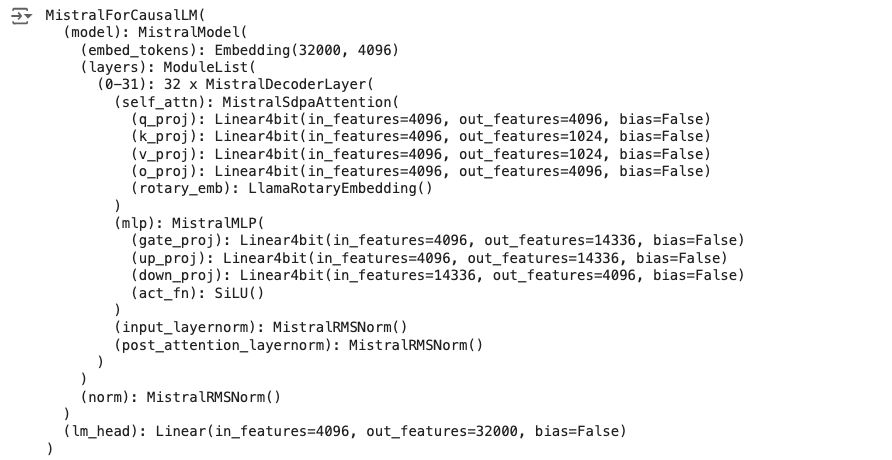

In [19]:
outputs = gpt2_model(**inputs)

In [20]:
outputs.logits.shape

torch.Size([2, 9, 50257])

In [21]:
outputs = gpt2_model.generate(**inputs)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [22]:
gpt2_tokenizer.batch_decode(outputs)

['<|endoftext|><|endoftext|><|endoftext|><|endoftext|>This is an awesome movie. I love it. I love it. I love',
 '<|endoftext|><|endoftext|><|endoftext|><|endoftext|>Great action set pieces overall.\n\nThe game is a bit of a mess']

# From Decoder-only Models to Instruction Tuned LLMs

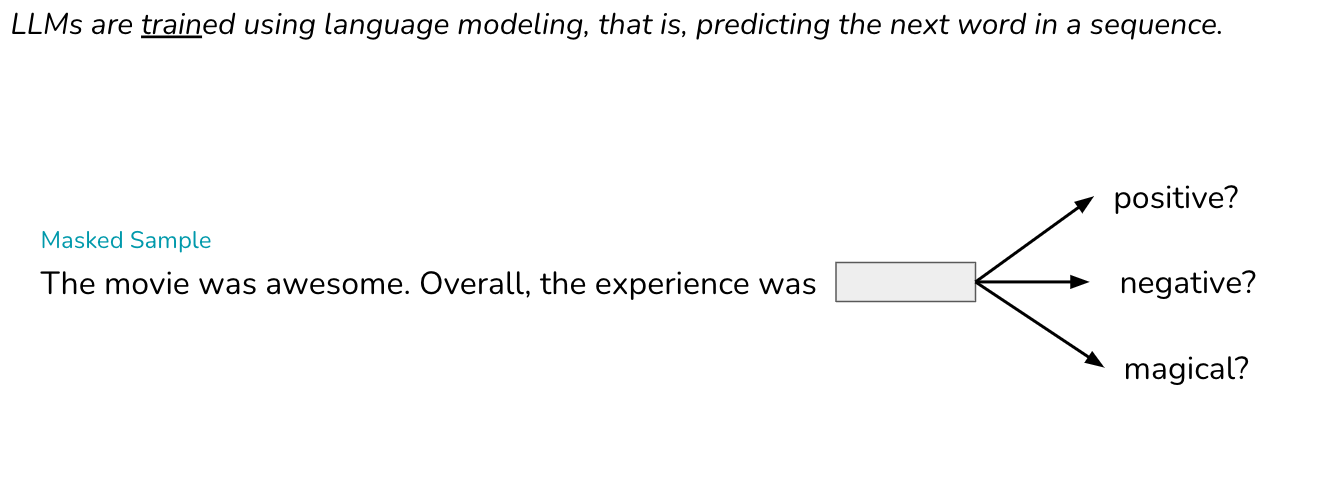

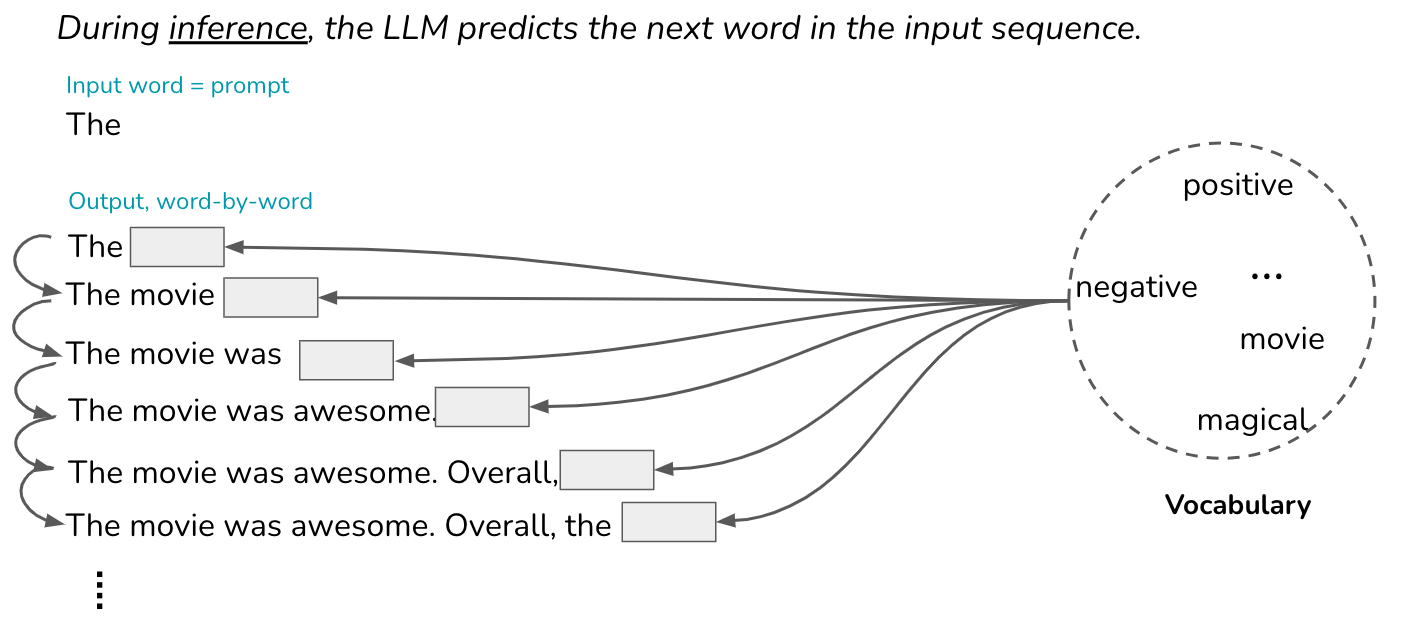

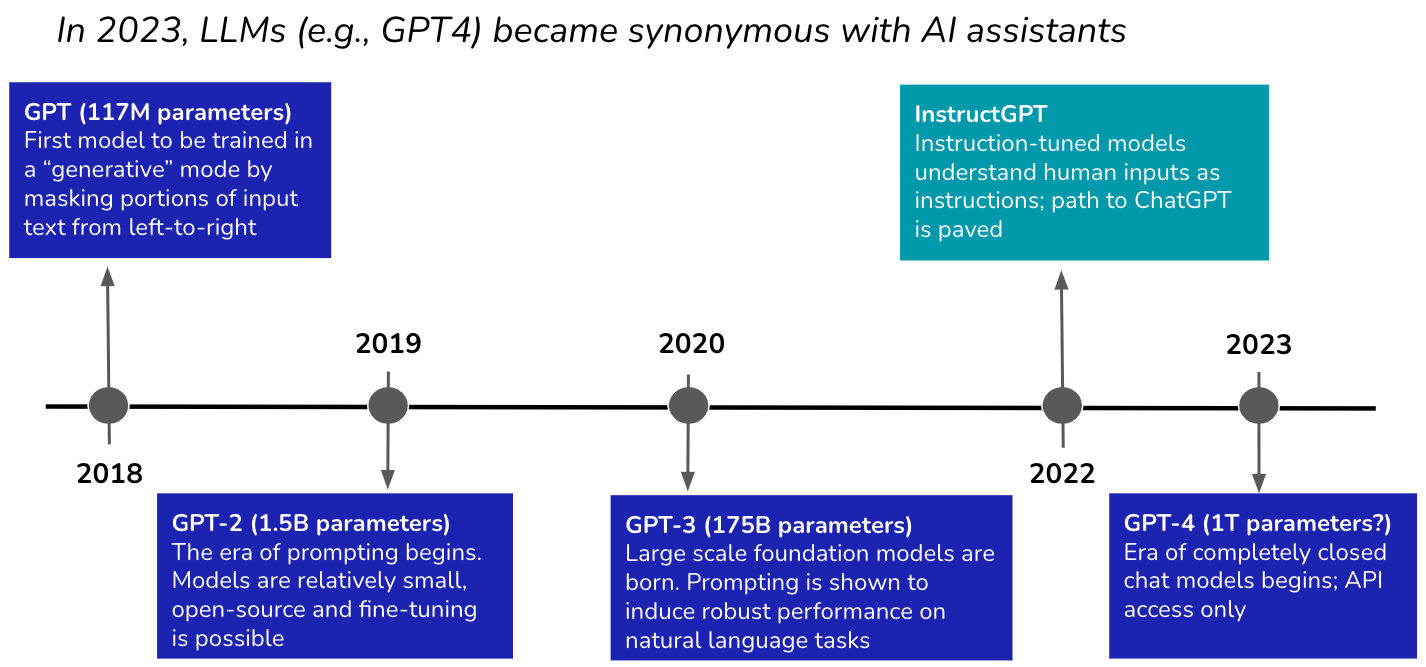

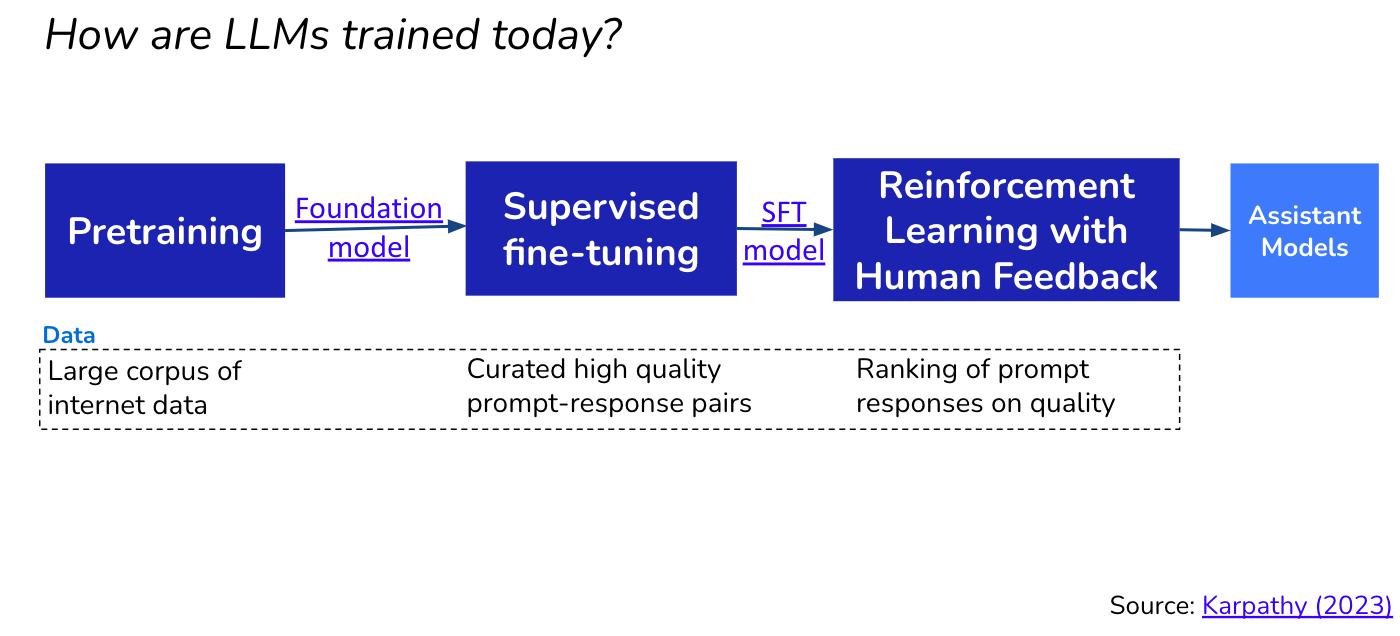

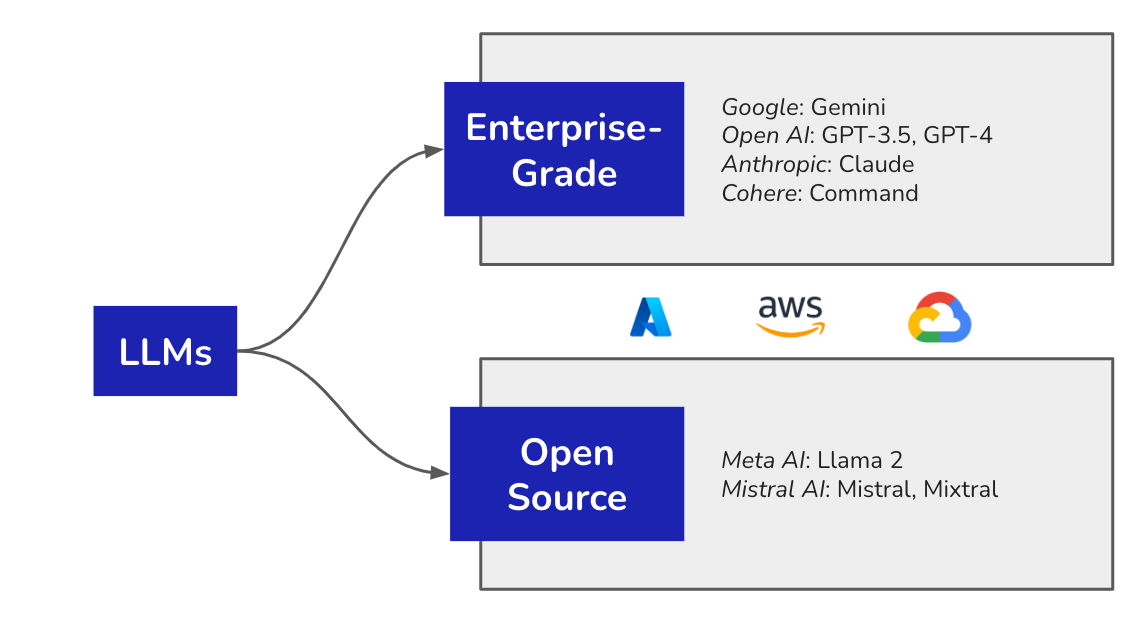

# LLMs for Enterprise Applications

In general, the three classes of problems that LLMs can solve with a high degree of accuracy are presented below (for each class we also present a representative example).

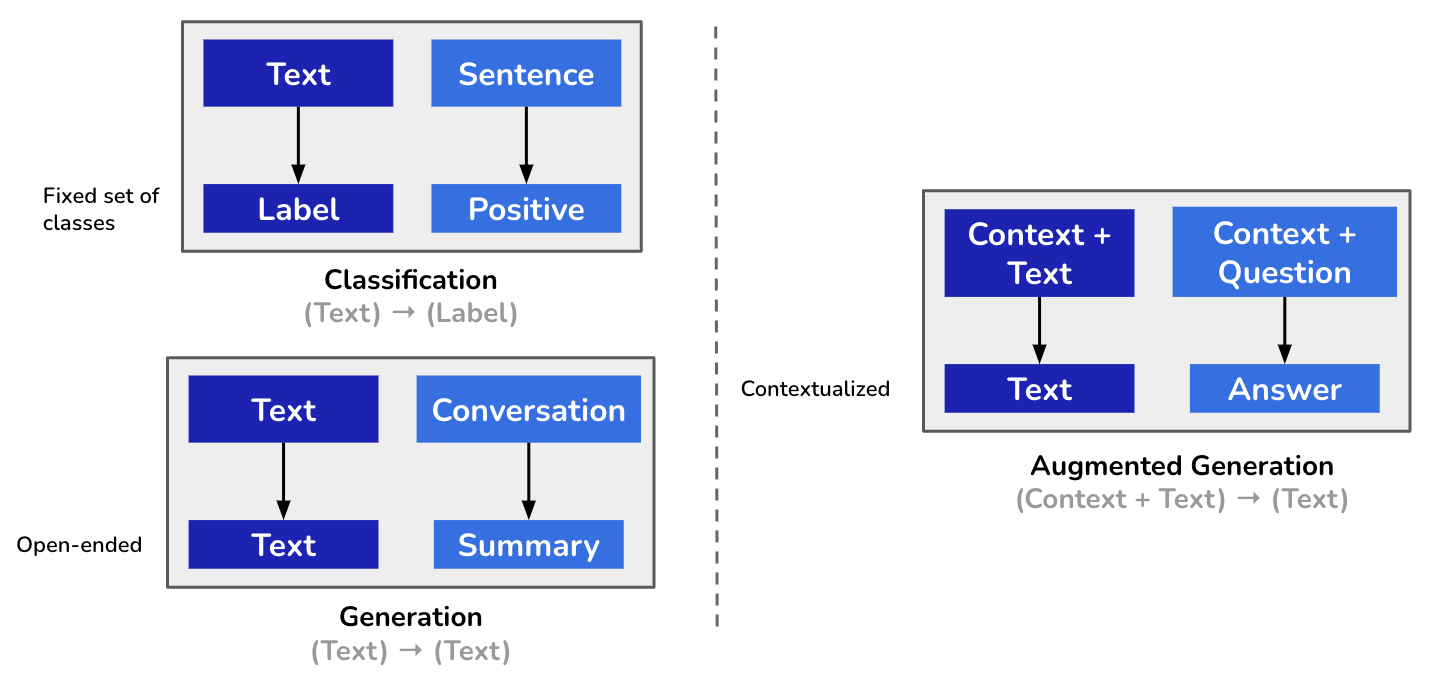

Some examples of each of these classes of problems are:

**Text-to-Label:**

1. *Customer Support Ticket Classification:*
   - *Input*: Customer support tickets or emails.
   - *Output Classes*: Categories such as "Billing Issue," "Technical Support," "Product Inquiry," etc.

2. *Sentiment Analysis for Product Reviews:*
   - *Input*: Product reviews or comments.
   - *Output Classes*: "Positive," "Negative," or "Neutral" sentiment.

3. *Topic Categorization for News Articles:*
   - *Input*: News articles.
   - *Output Classes*: "Politics," "Sports," "Entertainment," etc.

4. *Resume Screening:*
   - *Input*: Job applicant resumes.
   - *Output Classes*: "Suitable for Interview," "Not Suitable," etc.

5. *Social Media Post Classification:*
   - *Input*: Social media posts.
   - *Output Classes*: "News," "Events," "Personal Updates," etc.

6. *Legal Document Categorization:*
   - *Input*: Legal documents.
   - *Output Classes*: "Contract," "Complaint," "Agreement," etc.

7. *Product Categorization for E-commerce:*
   - *Input*: Product descriptions.
   - *Output Classes*: "Electronics," "Clothing," "Home Appliances," etc.

8. *Medical Record Classification:*
   - *Input*: Electronic health records.
   - *Output Classes*: "Diagnosis," "Medication," "Treatment Plan," etc.

**Text-to-Text**

1. *Customer Support Automation:*
   - *Input:* Customer inquiries or complaints in text form.
   - *Output:* Automated responses or suggested solutions generated in response to customer queries.

2. *Email Autoresponders:*
   - *Input:* Incoming emails.
   - *Output:* Automatic email responses generated based on predefined rules or machine learning algorithms.

3. *Text Summarization:*
   - *Input:* Long documents, articles, or text passages.
   - *Output:* Summarized versions of the input text, condensing the key information.

4. *Content Generation:*
   - *Input:* Prompts or specifications for content creation.
   - *Output:* Generated articles, stories, or creative pieces in response to the input.

5. *Code Generation:*
    - *Input:* Descriptions or requirements for a program.
    - *Output:* Automatically generated code based on the input specifications.

6. *Automated Report Generation:*
    - *Input:* Data sets or parameters.
    - *Output:* Automatically generated reports or summaries describing the data.

7. *Social Media Posting:*
    - *Input:* Drafts or prompts for social media posts.
    - *Output:* Published social media content.

**Retrieval-Augmented Generation**

Retrieval augmented generation combines the benefits of retrieval-based models, which fetch information from a predefined set of documents or data, with generative models that can create new content. Here are some business examples of retrieval augmented generation:

1. *Customer Support Chatbots:*
   - *Retrieval:* The system retrieves information from a knowledge base or FAQs to understand customer queries.
   - *Generation:* It generates human-like responses by incorporating retrieved information and adapting it to the specific context of the customer's query.

2. *Content Creation for E-commerce:*
   - *Retrieval:* The model retrieves product information, customer reviews, and other relevant details from the e-commerce platform's database.
   - *Generation:* It generates unique product descriptions, marketing copy, or answers to customer inquiries by combining and rephrasing the retrieved information.

3. *Legal Document Generation:*
   - *Retrieval:* The model retrieves legal precedents, case studies, and relevant statutes from legal databases.
   - *Generation:* It generates drafts of legal documents, contracts, or briefs by incorporating retrieved legal information and tailoring it to the specifics of the current case.

4. *HR Policy and Procedure Creation:*
   - *Retrieval:* The system retrieves existing HR policies, industry regulations, and best practices from internal databases or external sources.
   - *Generation:* It generates customized HR policies, employee handbooks, or procedural documents by combining retrieved information and adapting it to the company's specific needs.

5. *Automated Report Generation:*
   - *Retrieval:* The model retrieves data, charts, and statistics from databases or analytics platforms.
   - *Generation:* It generates comprehensive reports by combining the retrieved data and creating insightful narratives and analyses.

6. *Technical Documentation Generation:*
   - *Retrieval:* The model retrieves information from technical manuals, documentation, and code repositories.
   - *Generation:* It generates user-friendly technical documentation, code comments, or troubleshooting guides by incorporating and rephrasing the retrieved technical details.

7. *News Article Summarization:*
   - *Retrieval:* The system retrieves news articles, reports, and related information.
   - *Generation:* It generates concise and informative news article summaries by combining and rephrasing key points from the retrieved content.

## The ChatCompletions API

Since we will be using assistant models to accomplish business tasks, the prompt should follow a specific structure that was used during LLM training. Further, there are a few parameters of the LLM APIs that control the output from the model. Let us look at each of these in turn.

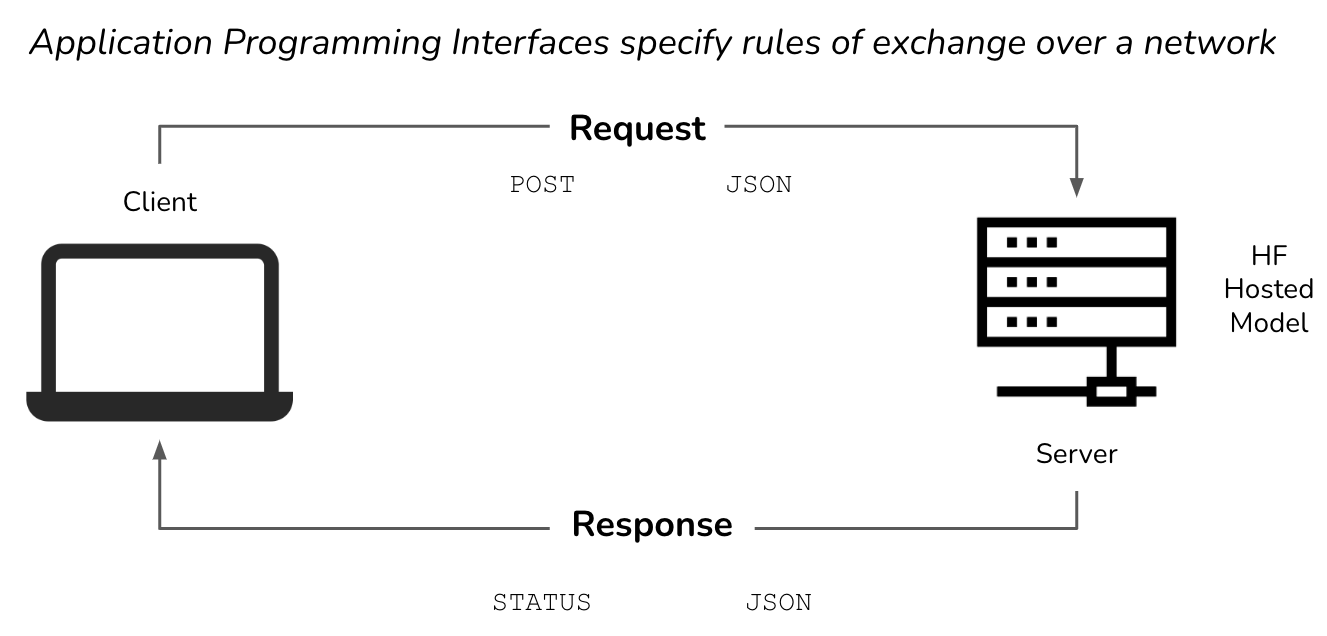

### Prompt structure

The prompt is presented to the chat completions API as a list of dictionaries with three roles - `system`, `user` and `assistant`. The `system` and `assistant` roles are optional (see figure below).

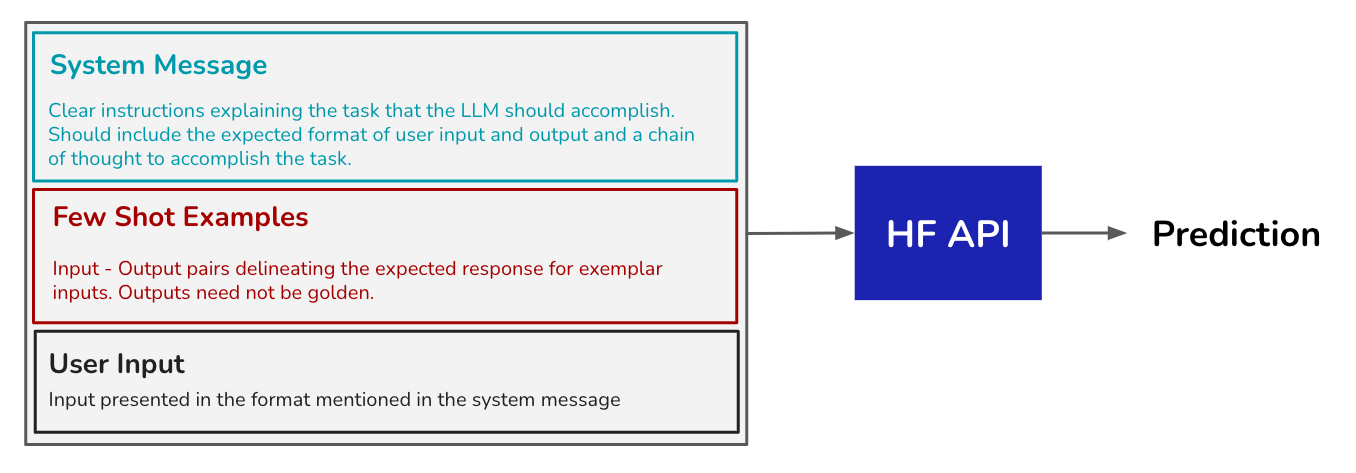

Let us look at a few examples of this input specification in action.

In [23]:
system_message = """
Assign sentiment to the product review presented in the user input.
Answer in only one word - positive or negative.
Do not explain your answer.
"""

In [24]:
user_input = """
### Review:
The price is definitely justified for airpods pro 2.
Pros:

- noise cancellation is amazing
- Dolby Atmos perfect
- spatial audio works accurately, head tracking so good
- I can hear more instruments in the songs which I didn't hear it before😀
- the earpods volume will be lowered if you're start speaking to someone, I was suprised about this feature

Cons:

- touch controls placement is at the end of the earpods, means you have to slightly touch it to operate the volume or next song. Etc..since my fingers are big I found it little difficult operate
Assign sentiment to the following product review. Answer only in one word.
"""

With this inputs in place, we can create a chat completion like so:

In [25]:
client = InferenceClient(
    "mistralai/Mistral-7B-Instruct-v0.3",
    token=" "
)

In [26]:
response = client.chat_completion(
	messages=[
		   {"role": "system", "content": system_message},
		    {"role": "user", "content": user_input}
    ],
	max_tokens=2
)


In [27]:
response.choices[0].message.content

'Positive'

We can also extract the number of tokens used by accessing the `usage` like so.

In [28]:
response.usage.total_tokens

201

Let us look at a little more involved example with a more fleshed out `system_message`. Let us use the LLM to extract structured output from input text. The objective here is to illustrate best practises on system message composition.

In [29]:
system_message = """
You are an assistant to a hospital administration team working on extracting important information from medical notes made by doctors.
Medical notes will be presented to you in the user input.
Extract relevant information as mentioned below in a json format with the following schema.
- age: integer, age of the patient
- gender: string, can be one of male, female or other
- diagnosis: string, can be one of migraine, diabetes, arthritis and acne
- weight: integer, weight of the patient
- smoking: string, can be one of yes or no
Do not add any extra information before or after the JSON output.
"""

In [30]:
user_input = """
Medical Notes:
---
A 35-year-old male patient, Mr. Nags, presented with symptoms
of increased thirst, frequent urination, fatigue, and unexplained
weight loss. Upon evaluation, he was diagnosed with diabetes,
confirmed by elevated blood sugar levels. Mr. Johnson's weight
is 80 kgs. He has been prescribed Metformin to be taken twice daily
with meals. It was noted during the consultation that the patient is
a current smoker.
"""

In [31]:
response = client.chat_completion(
	messages=[
		   {"role": "system", "content": system_message},
		    {"role": "user", "content": user_input}
    ]
)

In [32]:
print(response.choices[0].message.content)

{
  "age": 35,
  "gender": "male",
  "diagnosis": "diabetes",
  "weight": 80,
  "smoking": "yes"
}


In [33]:
user_input = """
Medical Notes:
---
Patient Name: Ms. Krishnaveni
Age: 45 years
Gender: Female

Chief Complaint:
Ms. Krishnaveni presented with complaints of persistent abdominal pain, bloating, and changes in bowel habits over the past two months.

History of Present Illness:
Ms. Krishnaveni reports experiencing intermittent abdominal pain, predominantly in the lower abdomen, accompanied by bloating and alternating episodes of diarrhea and constipation. She describes the pain as crampy in nature, relieved partially by defecation but worsening after meals. There is no association with specific food items. She denies any rectal bleeding, unintended weight loss, or fever.

Past Medical History:
Ms. Krishnaveni has a history of irritable bowel syndrome (IBS), diagnosed five years ago, managed with dietary modifications and occasional use of over-the-counter antispasmodics.

Medications:
She occasionally takes over-the-counter antispasmodics for symptomatic relief of abdominal discomfort related to IBS.

Family History:
There is no significant family history of gastrointestinal disorders or malignancies.

Social History:
Ms. Krishnaveni is a non-smoker and does not consume alcohol. She works as a teacher in a local school.
"""

In [34]:
response = client.chat_completion(
	messages=[
		   {"role": "system", "content": system_message},
		    {"role": "user", "content": user_input}
    ]
)

In [35]:
print(response.choices[0].message.content)

{
  "age": 45,
  "gender": "Female",
  "diagnosis": "irritable bowel syndrome (IBS)",
  "weight": null,
  "smoking": "no"
}


Notice how even though the input format is completely different, the model was able to extract structured information from the medical note. Also when a required parameter is absent, it reported a `None` value.

Now that we know how to structure the prompt, let us look at other parameters of the API that control the generation.

### API parameters

A summary of other API parameters presented along with the input prompt that control the completion are summarized below.

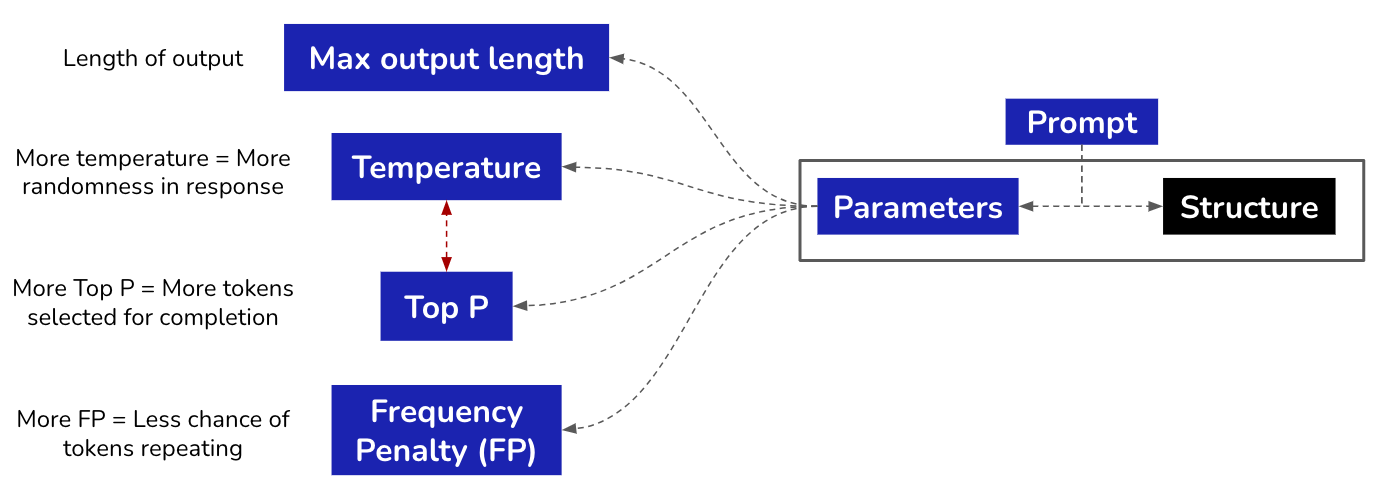

These parameters control the inference process of the LLM. Two important parameters that modify the nature of output from the LLM are: `temperature` and `max_tokens`. Among the two, temperature (between the range 0 and 1) is the most important parameter that controls the variability in the output.


#### Temperature


In situations where a creative output is expected, having a high temperature (close to 1) is beneficial. This is because each completion generates a slightly different output and we can choose between the options presented.

When temperature is 0, this is equivalent to a deterministic scenario where the most likely token (as predicted by the LLM) is always chosen across different runs of the same prompt.


Here is a summary of how the parameter temperature impacts the generation process:

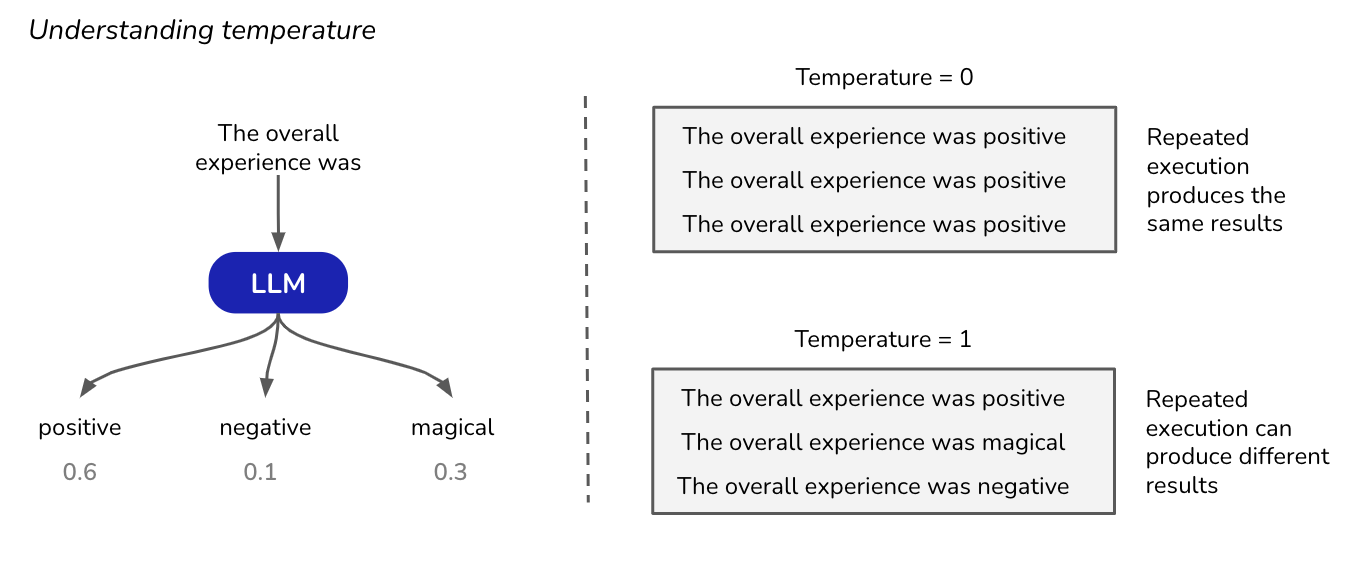

By adjusting temperature, we essentially adjust the probability distribution of the next word during text generation. Temperature is defined as the inverse of the scaling factor applied to adjust the logits before implementing the softmax function. This adjustment controls the degree of randomness in the generated output. A higher temperature setting results in lower probabilities, leading to more creative and random outputs. Conversely, a lower temperature setting increases probabilities, resulting in more predictable outputs. Therefore, the temperature parameter influences the balance between randomness and determinism in text generation.

In [36]:
user_input = """
You are a marketer for the gaming company Razer.
Below is the metadata about the Razer Ornata V3 X gaming keyboard:
Brand: Razer
Series: Ornata V3 X
Item model number: RZ03-04470200-R3U1
Hardware Platform: PC
Operating System: Microsoft Windows
Item Weight: 2.97 pounds
Product Dimensions: 17.46 x 5.68 x 1.23 inches
Item Dimensions LxWxH: 17.46 x 5.68 x 1.23 inches
Color: Classic Black
Manufacturer: Razer
Language: English
ASIN: B09X6GJ691
Special Features: Low-Profile Keys, Spill Resistant, Ergonomic Wrist Rest, Chroma RGB Lighting, Silent Membrane Switches, Cable Routing Options
With this information, write a sleek "About this item" description that will be used on its Amazon product page.
Use bullet points to delineate key features mentioned in the description.
"""

In [37]:
response = client.chat_completion(
	messages=[{"role": "user", "content": user_input}],
    temperature=0.4,
    max_tokens=256
)

In [38]:
print(response.choices[0].message.content)

**About this item**

🌐 Brand: Razer
🎮 Series: Ornata V3 X
🛍️ Item Model Number: RZ03-04470200-R3U1

Experience the future of gaming with the Razer Ornata V3 X, a low-profile keyboard designed to elevate your gaming experience.

💻 Hardware Platform: PC
🔰 Operating System: Microsoft Windows

This sleek gaming keyboard is engineered for seamless compatibility with your PC, ensuring a smooth and efficient gaming experience.

🔍 Item Weight: 2.97 pounds
📏 Product Dimensions: 17.46 x 5.68 x 1.23 inches

Compact and portable, the Ornata V3 X fits comfortably on any desk, making it perfect for both home and LAN parties.

🌌 Color: Classic Black
🇬🇧 Language: English

The Ornata V3 X boasts a classic black design and is available in English,


Reducing the temperature reduces variability in generation.

In [39]:
response = client.chat_completion(
	messages=[{"role": "user", "content": user_input}],
    temperature=0,
    max_tokens=256
)

In [40]:
print(response.choices[0].message.content)

**About this item**

🎮 **Brand:** Razer

💻 **Series:** Ornata V3 X

🛍️ **Item model number:** RZ03-04470200-R3U1

💻 **Hardware Platform:** PC

📝 **Operating System:** Microsoft Windows

🔍 **Weight:** 2.97 pounds, compact and portable for your gaming setup.

📏 **Dimensions:** 17.46 x 5.68 x 1.23 inches, designed to fit comfortably on your desk.

🌌 **Color:** Classic Black, a sleek and stylish addition to your gaming station.

💧 **Spill Resistant:** Protecting your keyboard from accidental spills and stains.

🤚 **Ergonomic Wrist Rest:** Comfortable support for those long gaming sessions.

💡 **Chroma RGB Lighting:** Customize your keyboard with 16.8 million colors and lighting effects


#### Maximum tokens

The parameter (`max_tokens`) refers to the maximum number of tokens that can be generated in the chat completion. With this parameter, we can modify the output length like so:

In [41]:
response = client.chat_completion(
	messages=[{"role": "user", "content": user_input}],
    temperature=0.4,
    max_tokens=1024
)

In [42]:
print(response.choices[0].message.content)

**About this item**

🎮 **Brand:** Razer

💻 **Series:** Ornata V3 X

🛍️ **Item model number:** RZ03-04470200-R3U1

🖥️ **Hardware Platform:** PC

📲 **Operating System:** Microsoft Windows

📦 **Item Weight:** 2.97 pounds

📏 **Product Dimensions:** 17.46 x 5.68 x 1.23 inches

📏 **Item Dimensions LxWxH:** 17.46 x 5.68 x 1.23 inches

🌐 **Color:** Classic Black

🏭 **Manufacturer:** Razer

🔔 **Language:** English

🛍️ **ASIN:** B09X6GJ691

🌈 **Special Features:**

- **Low-Profile Keys:** Compact design for efficient gaming and typing.
- **Spill Resistant:** Protects your keyboard from accidental liquid spills.
- **Ergonomic Wrist Rest:** Comfortable support for long gaming sessions.
- **Chroma RGB Lighting:** Customize your keyboard's lighting to match your gaming setup.
- **Silent Membrane Switches:** Quiet keys for a peaceful gaming environment.
- **Cable Routing Options:** Neatly manage your cables for a clean and organized setup.


Note that the total length of input tokens and generated tokens is still limited by the model's context length (16,384 for Mistral).

# Text - Label Tasks

## Overview

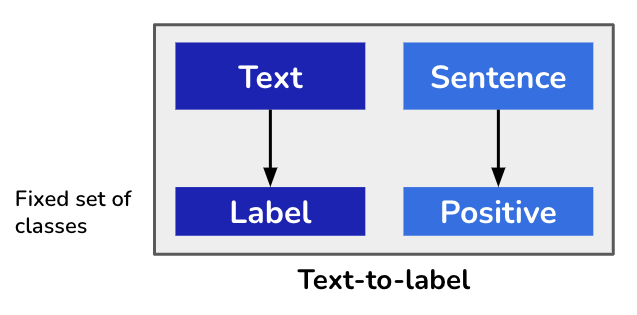

Text-to-label tasks are a core NLP task where the objective is to classify input text to a predefined set of classes. LLMs achieve high accuracy on these with a far lesser data requirement and no model training. In this notebook we will look at how LLM prompts could be designed and evaluated for text-to-label tasks using sentiment analysis as an example. The approach in this notebook can be extended to any other classification task.

We begin by presenting a workflow for prompt design and evaluation for classification tasks.

## Workflow

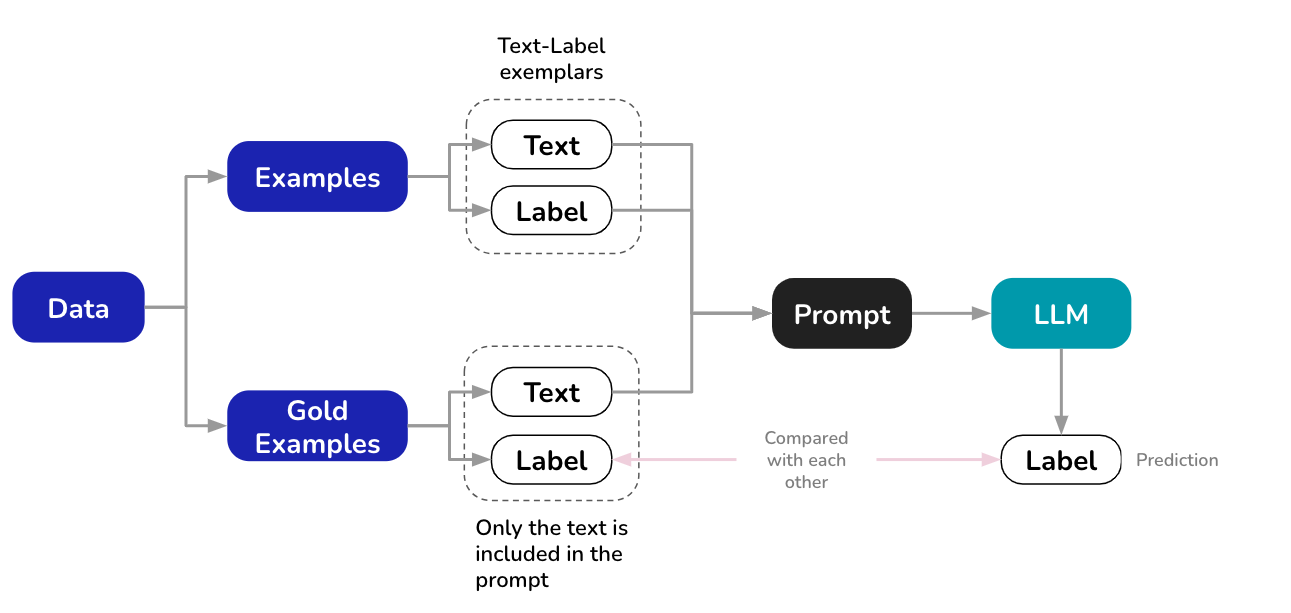

As indicated in the above figure, we do need data to prime the LLM for classification tasks. However, when using LLMs, the requirement on data is several order of magnitudes lesser since there is no training involved. Data used to achieve classification tasks comprises examples and gold examples. Examples are input-output exemplars (usually not more than 8) included in the prompt to prime it for expected label generation. Gold examples are inputs for evaluation where we have ground truth available and predictions from the LLM for the inputs is compared with the ground truths. We choose the best *prompt* as the one that scores high on predefined metrics (e.g., accuracy, F1 score) on the set of gold examples.

Note that we are avoiding the usage of train and test data here to reinforce the idea that there is no model training involved here. While conceptually the idea of examples and gold examples is similar to train and test data, the similarity ends there since there is no model training.

## Evaluation

Performance of prompts for classification tasks can be measured using accuracy, and/or F1 score.

**Accuracy:**

Accuracy measures the proportion of correctly classified instances out of the total number of instances. It is calculated as the number of true positives (correctly classified instances) divided by the total number of instances. Accuracy provides a straightforward measure of a model's overall performance, but it can be misleading if the classes are imbalanced.

**F1 Score:**

The F1 score, also known as the F1 measure or F-score, is a measure of the model's accuracy and precision. It is calculated as the harmonic mean of precision and recall. Precision measures the proportion of true positives among all predicted positive instances, while recall measures the proportion of true positives among all actual positive instances. The F1 score provides a more comprehensive evaluation of a model's performance, as it takes into account both precision and recall.

Let us now implement this workflow for sentiment analysis on a sample of IMDB reviews.

# Sentiment Analysis

## Prompt Design

We will design a few-shot prompt for sentiment analysis. We first assemble a set of examples (input-output exemplars) as a part of the few-shot prompt. Then we create the prompt in the Anyscale API format.

To evaluate the performance of the *prompt* we will use a set of *gold examples*, that is, a set of examples that is not presented to the model as a part of the prompt.  

**Examples and Gold Examples**

A set of examples and gold examples for sentiment classification of IMDB movie reviews is hosted on a HuggingFace dataset. Let us load this data and take a look at the samples in this data.

In [43]:
imdb = load_dataset("pgurazada1/imdb")

Generating examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

Generating gold_examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

As is evident from the above output, the data set has 32 samples as examples and 32 samples as gold examples.

In [44]:
imdb_examples_df = imdb['examples'].to_pandas()
imdb_gold_examples_df = imdb['gold_examples'].to_pandas()

In [45]:
imdb_examples_df.shape, imdb_gold_examples_df.shape

((32, 2), (32, 2))

In [46]:
imdb_examples_df.sample(4)

,text,label
16,The main reason I wanted to see this movie was...,1
3,"""Freddy's Dead"" did the smartest thing it coul...",0
0,i just saw Dick Tracy and I thought it was ter...,0
23,Can I Do it 'till I Need Glasses? at the very ...,0


As the above outputs indicate, there are 32 examples and 32 gold examples. We will sample from the examples to create the few shot prompt and evaluate the prompt on all 32 gold examples.

**Assembling the prompt**

In [47]:
system_message = """
Classify movie reviews in the input as positive (1) or negative (0) in sentiment.
Do not explain your answer. Your answer should only contain the label: 1 or 0.
"""

In [48]:
few_shot_prompt = [{'role':'system', 'content': system_message}]

We need to iterate over the rows of the examples DataFrame to append these examples as `user` and `assistant` messages to the few-shot prompt. We achieve this using the `iterrows` method.

In [49]:
for index, row in imdb_examples_df.iterrows():
    print('Example Review:')
    print(row.iloc[0])
    print('Example Label:')
    print(row.iloc[1])
    break

Example Review:
i just saw Dick Tracy and I thought it was terrible. The paintings in the background of the cities looked awful. Also the mob characters looked too weird. Warren Beatty didn't do an awful job as Dick Tracy but it was definetely not one of his better performances. Madonna should just stick to singing. Glenne Headly did a good job in this movie. I gave this movie a 2/10 just because of the amazing acting by Al Pacino. It wasn't a high note in his career but he still did a good job.
Example Label:
0


Notice that the label is an integer. However, LLMs accept only strings. So we need to convert the integer label to a string label as we assemble the few-shot prompt. Let us assemble a few-shot prompt with 4 examples.

In [50]:
for index, row in imdb_examples_df.sample(4).iterrows():
    example_review = row.iloc[0]
    example_label = row.iloc[1]

    few_shot_prompt.append(
        {
            'role': 'user',
            'content': example_review
        }
    )

    few_shot_prompt.append(
        {
            'role': 'assistant',
            'content': str(example_label) # LLMs accept only string inputs
        }
    )

In [51]:
few_shot_prompt

[{'role': 'system',
  'content': '\nClassify movie reviews in the input as positive (1) or negative (0) in sentiment.\nDo not explain your answer. Your answer should only contain the label: 1 or 0.\n'},
 {'role': 'user',
  'content': "i just saw Dick Tracy and I thought it was terrible. The paintings in the background of the cities looked awful. Also the mob characters looked too weird. Warren Beatty didn't do an awful job as Dick Tracy but it was definetely not one of his better performances. Madonna should just stick to singing. Glenne Headly did a good job in this movie. I gave this movie a 2/10 just because of the amazing acting by Al Pacino. It wasn't a high note in his career but he still did a good job."},
 {'role': 'assistant', 'content': '0'},
 {'role': 'user',
  'content': "Well I must say this is probably the worst film I have seen this year! The jokes were extremely crude (wasn't expecting it from as PG movie)(Rated PG in Canada) and they weren't funny! With this great cast

We now have 4 examples in the few shot prompt that is ready for use. Before we deploy this prompt, we need to get an estimate of the performance of this prompt. Here is where we use gold examples to estimate the accuracy.

## Evaluation

In [52]:
predictions, ground_truths = [], []

In [53]:
for index, row in imdb_gold_examples_df.iterrows():
    gold_review = row.iloc[0]
    gold_label = row.iloc[1]

    user_input = [{'role':'user', 'content': gold_review}]

    try:
        response = client.chat_completion(
            messages=few_shot_prompt + user_input,
            temperature=0,
            max_tokens=2
        )

        predictions.append(int(response.choices[0].message.content)) # convert the string label back to int
        ground_truths.append(gold_label)
    except Exception as e:
        print(e) # Log error and continue
        continue

In [54]:
predictions = np.array(predictions)
ground_truths = np.array(ground_truths)
(predictions == ground_truths).mean()

0.90625

# Text - Text Generation Tasks

## Overview

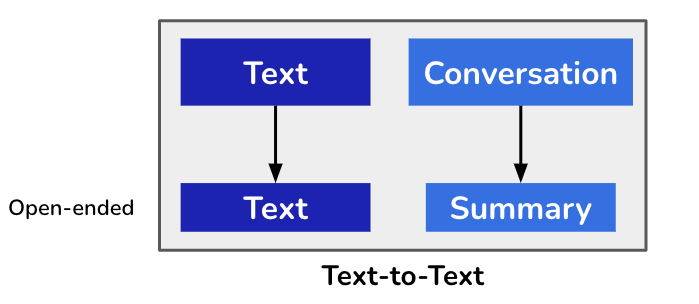

Text-to-Text generation problems are another class of important problems that LLMs solve effectively. In this notebook, we present an approach to design and evaluate prompts for text-to-text tasks using summarization as an example. The approach followed in this notebook can be extended to any other text-to-text task as well.

We begin by presenting a workflow for prompt design and evaluation for text generation tasks.

## Workflow

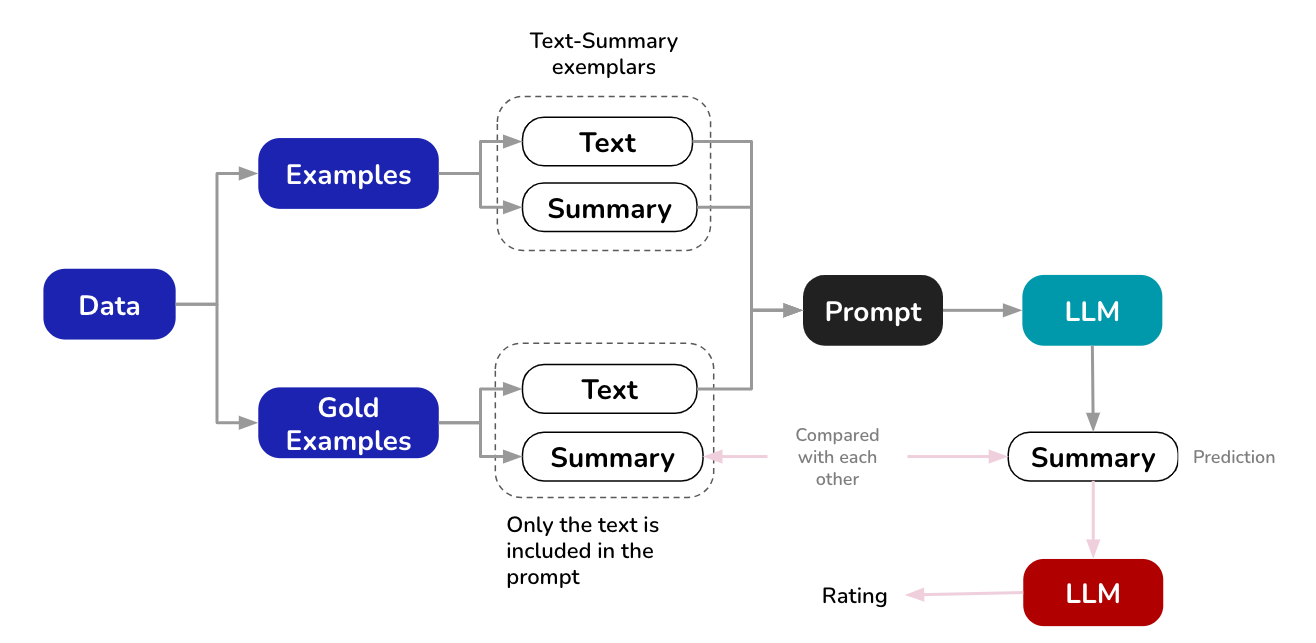

As indicated in the above figure, the data used to achieve text generation tasks comprises examples and gold examples. Examples are input-output exemplars included in the prompt to prime it for expected output generation. Gold examples are inputs for which we have ground truth available and predictions from the LLM for the inputs is compared with the ground truths. We choose the best *prompt* as the one that scores high on predefined metrics on the set of gold examples. Unlike classification though, here we have to contend with subjective output. This complicates the evaluation process (including the difficulty in collecting human generated baselines), and it is common to use LLMs to evaluate the quality of outputs (referred to as LLM-as-a-judge).  

## Evaluation

Given the subjective nature of text generation, there are two ways in which generation tasks could be evaluated.

- When human annotations are available, evaluation is done using BERTScore. BERTScore is an automatic evaluation metric for text generation tasks that leverages the pre-trained contextual embeddings from BERT to compute the semantic similarity between the generated text (candidate) and the reference text, rather than relying on exact token matches.

- When human annotations are not available, we use another LLM to rate the performance of the LLM used in the generation task (see figure below for an example in case of summarization). This method of using LLMs to evaluate LLMs is usualy referred to as LLM-as-a-judge. When LLMs are used to evaluate output, the system message should clearly define the rubrics used for evaluation and the key aspects of the output that should be evaluated. The advantage of using LLMs as judges is that we do not need human baselines (that are costly to collect), while writing down the rubrics for assessment is usually an easier task.

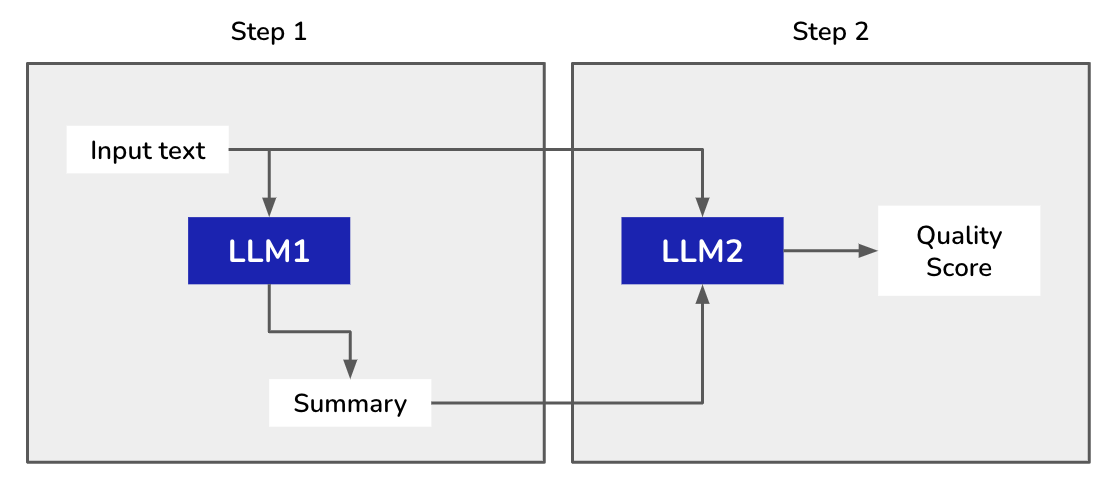

Let us now implement this workflow for diaogue summarization on a sample of conversations.

# Summarization

## Prompt Design

We will design a few-shot prompt for summarization. We first assemble a set of examples (input-output exemplars) as a part of the few-shot prompt. Then we create the prompt in the Anyscale API format.

To evaluate the performance of the *prompt* we will use a set of *gold examples*, that is, a set of examples that is not presented to the model as a part of the prompt.  

**Examples and Gold Examples**

In [55]:
dataset = load_dataset("pgurazada1/dialogsum")

Generating examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

Generating gold_examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

**Assembling the prompt**

Let us now assemble 4 examples from this dataset of 32 dialogue examples. We also collect the 32 gold examples.

In [56]:
dialogue_summary_examples_df = dataset['examples'].to_pandas()
dialogue_summary_gold_examples_df = dataset['gold_examples'].to_pandas()

In [57]:
examples_df = dialogue_summary_examples_df.sample(4)

In [58]:
examples_df

,dialogue,summary
6,#Person1#: The boys in this picture look aweso...,#Person1#'s interested in the band R5. Susan i...
20,"#Person1#: Good afternoon. I am Mr. Brown, the...",It has been the fourth time for Mr. Brown to t...
0,#Person1#: Have you gone to school today?\n#Pe...,#Person1# couldn't go to school for the illnes...
26,#Person1#: I haven't seen you in a while. How ...,Both #Person1# and #Person2# need to find a jo...


We need to iterate over the rows of the examples DataFrame to append these examples as `user` and `assistant` messages to the few-shot prompt. We achieve this using the `iterrows` method.

In [59]:
for index, row in examples_df.iterrows():
    print('Example Dialogue:')
    print(row.iloc[0])
    print('Example Summary:')
    print(row.iloc[1])
    break

Example Dialogue:
#Person1#: The boys in this picture look awesome, Susan. Who are they?
#Person2#: There are members of a band called R5. Their music is really popular right now online. I'm a big fan. This boy here is Ross and these here are Rocky, Riker and Rydel Lynch. Oh, and this is Ellington Ratliff.
#Person1#: So who is this boy in the middle again?
#Person2#: That's Ross. He's the lead singer and plays the rhythm guitar.
#Person1#: What do the others do in the band?
#Person2#: Rocky is a guitarist. Rydell plays keyboard and Ratliff plays the drums.
#Person1#: Do you have one of their albums?
#Person2#: Yes, I just bought their main album last month. Do you want to borrow it? You can take it home and listen to it.
#Person1#: Yes, I'd love to.
Example Summary:
#Person1#'s interested in the band R5. Susan introduces the band to #Person1# and lends #Person1# the main album.


In [60]:
system_message = """
Summarize the dialogue mentioned in the user input. Be specific and concise in your summary.
"""

In [61]:
few_shot_prompt = [{'role':'system', 'content': system_message}]

We need to iterate over the rows of the examples DataFrame to append these examples as `user` and `assistant` messages to the few-shot prompt. We achieve this using the `iterrows` method.

In [62]:
for index, row in examples_df.iterrows():
    user_input_example = row.iloc[0]
    assistant_output_example = row.iloc[1]

    few_shot_prompt.append(
        {
            'role': 'user',
            'content': user_input_example
        }
    )

    few_shot_prompt.append(
        {
            'role': 'assistant',
            'content': assistant_output_example
        }
    )

In [63]:
few_shot_prompt

[{'role': 'system',
  'content': '\nSummarize the dialogue mentioned in the user input. Be specific and concise in your summary.\n'},
 {'role': 'user',
  'content': "#Person1#: The boys in this picture look awesome, Susan. Who are they?\n#Person2#: There are members of a band called R5. Their music is really popular right now online. I'm a big fan. This boy here is Ross and these here are Rocky, Riker and Rydel Lynch. Oh, and this is Ellington Ratliff.\n#Person1#: So who is this boy in the middle again?\n#Person2#: That's Ross. He's the lead singer and plays the rhythm guitar.\n#Person1#: What do the others do in the band?\n#Person2#: Rocky is a guitarist. Rydell plays keyboard and Ratliff plays the drums.\n#Person1#: Do you have one of their albums?\n#Person2#: Yes, I just bought their main album last month. Do you want to borrow it? You can take it home and listen to it.\n#Person1#: Yes, I'd love to."},
 {'role': 'assistant',
  'content': "#Person1#'s interested in the band R5. Susan

We now have 4 examples in the few shot prompt that is ready for use. Before we deploy this prompt, we need to get an estimate of the performance of this prompt. Here is where we need gold examples to get a baseline estimate.

## Evaluation

In [64]:
predictions, ground_truths = [], []

In [65]:
for index, row in dialogue_summary_gold_examples_df.iterrows():
    gold_dialogue = row.iloc[0]
    gold_summary = row.iloc[1]

    user_input = [{'role':'user', 'content': gold_dialogue}]

    response = client.chat_completion(
        messages=few_shot_prompt + user_input,
        temperature=0.2
    )

    predictions.append(response.choices[0].message.content)
    ground_truths.append(gold_summary)

We now have a set of summaries from the LLM and we want to understand if the summary is a good reflection of the content of the dialogue. To accomplish this, we could use a more powerful model to act as a judge. We also have human baseline summaries for the same conversation and we could use BERTScore to compare the predictions and ground truths. Let us now run evaluations using both these methods.

**BERTScore**

In [68]:
bertscore = load("bertscore")

In [69]:
results = bertscore.compute(
    predictions=predictions,
    references=ground_truths,
    lang="en"
)

/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
sum(results['f1'])/len(results['f1'])

0.8906438648700714

The above score indicates that the summarization was of very high quality,

**LLM-as-a-judge**

A general prompt that can be used when LLMs are used as judges is presented below.

In [71]:
rater_system_message = """
You are tasked with rating AI-generated summaries of dialogues based on the given metric.
You will be presented a dialogue and an AI generated summary of the dialogue as the input.
In the input, the dialogue will begin with ###Dialogue while the AI generated summary will begin with ###Summary.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the summary.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
The summary should cover all the aspects that are majorly being discussed in the dialogue.

Instructions:
1. First write down the steps that are needed to evaluate the summary as per the metric.
2. Give a step-by-step explanation if the summary adheres to the metric considering the dialogues as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the summary using the evaluaton criteria and assign a score.
"""

Notice how the rubric is clearly defined. Also the metric used to judge the output is clearly delineated. This prompt can be readily adapted to create multiple raters,e ach focusing on one metric.

In [72]:
rater_user_message_template = """
###Dialogue
{dialogue}

###Summary
{summary}
"""

In [73]:
ratings = []

In [74]:
for gold_dialogue, prediction in zip(dialogue_summary_gold_examples_df.dialogue, predictions):

    rater_prompt = [
        {'role': 'system',
         'content': rater_system_message
        },
        {
            'role': 'user',
            'content': rater_user_message_template.format(
                dialogue=gold_dialogue,
                summary=prediction
            )
        }
    ]

    response = client.chat_completion(
        messages=rater_prompt,
        temperature=0.2,
        max_tokens=1024
    )

    ratings.append(response.choices[0].message.content)

In [75]:
pd.DataFrame(
    {'dialogue': dialogue_summary_gold_examples_df.dialogue,
     'prediction': predictions,
     'rating': ratings
     }
)

,dialogue,prediction,rating
0,#Person1#: do you have any plans for dinner to...,"#Person1# suggests making dinner together, and...",Steps to evaluate the summary:\n1. Identify th...
1,#Person1#: Are you an art aficionado?\n#Person...,Person1 and Person2 discuss their interest in ...,Steps to evaluate the summary:\n1. Identify th...
2,"#Person1#: Sally,here is a letter for us. It's...",Person1 gives Person2 a letter from Tom. The l...,Steps to evaluate the summary:\n1. Identify th...
3,"#Person1#: So, did I tell you about my New Yea...",Person1 has decided to go on a diet as their N...,Steps to evaluate the summary:\n1. Identify th...
4,#Person1#: I'm coming to pick up my ticket. Th...,#Person1# arrives to pick up a ticket and is g...,Steps to evaluate the summary:\n1. Identify th...
5,"#Person1#: Hi, Dan, I'm calling to check on th...",Darlene calls Dan to check on an order of 100 ...,Steps to evaluate the summary:\n1. Identify th...
6,"#Person1#: Tom, I've got good news for you.\n#...",Person1 informs Person2 that their novel has w...,Steps to evaluate the summary:\n1. Identify th...
7,#Person1#: How did your company's fundraiser g...,The dialogue is about a successful fundraiser ...,Steps to evaluate the summary:\n1. Identify th...
8,"#Person1#: OK, Mrs Thomas. I finished cleaning...",James finished cleaning up the leaves in the y...,Steps to evaluate the summary:\n1. Identify th...
9,#Person1#: Mr. Wilson. We are very regretful a...,Person1 apologizes for the mistakes in goods a...,Steps to evaluate the summary:\n1. Identify th...


These detailed ratings could be used to diagnose issues with the prompt or the model used.

# Retrieval-Augmented Generation (RAG)

An important application of LLMs is enabling users to query unstructured data in natural language. This is finding a lot of traction in industries where the data is naturally unstructured in nature (e.g., finance, healthcare). The figure below shows how the finance sector is utilizing LLMs to query and summarize documents.

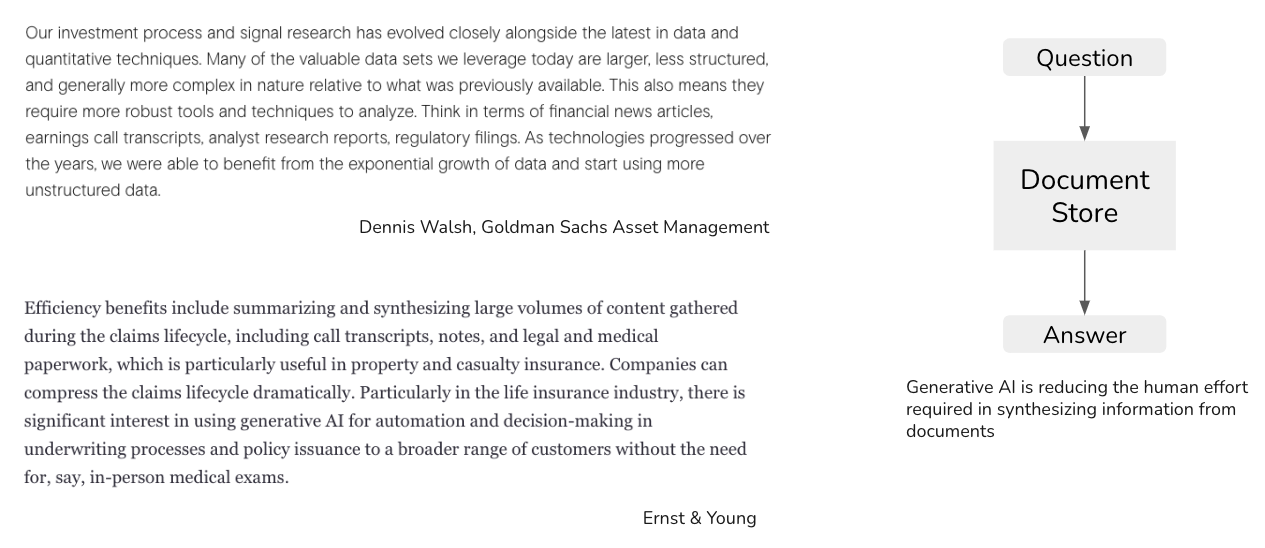

Document-based Q&A is achieved using Retrieval-Augmented Generation (RAG). RAG is a technique that combines the capabilities of pre-trained large language models (LLMs) with external data sources to generate more accurate and informative text. The key ideas are:

1. Bridging the gap between generative models and external knowledge: RAG integrates LLMs, which excel at generating fluent text, with retrieval models that can access and incorporate relevant information from external knowledge bases or databases.

2. Improving contextual understanding and content generation: By accessing external information, RAG models can generate text that is not only fluent but also grounded in real-world knowledge, leading to more accurate and contextually relevant responses. This is particularly useful for tasks like question-answering, summarization, and dialogue systems.

3. Reducing bias and misinformation: RAG can help verify generated content against external sources, incorporating diverse perspectives and producing more balanced and factually accurate outputs. This helps address issues of bias and misinformation that can arise in standalone LLMs.

4. Flexibility and scalability: RAG architectures are designed to be flexible and adaptable, allowing them to leverage domain-specific knowledge bases and scale effectively to handle large-scale information sources.

5. Continuous learning and improvement: RAG systems can be designed to continuously learn and improve over time by incorporating feedback mechanisms and iterative refinement processes. This contributes to the long-term effectiveness and reliability of RAG-powered applications.

In summary, RAG combines the strengths of generative language models and retrieval models to produce text that is more accurate, contextually relevant, and grounded in external knowledge, addressing key limitations of standalone LLMs.

The figure below summarizes the key idea of RAG.

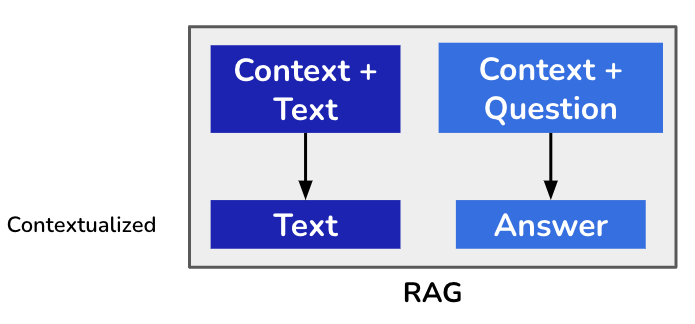

# RAG Building Blocks

## A workflow for RAG

The figure below depicts the key stages involved in designing a RAG solution using LLMs. Let us look at each stage in detail.

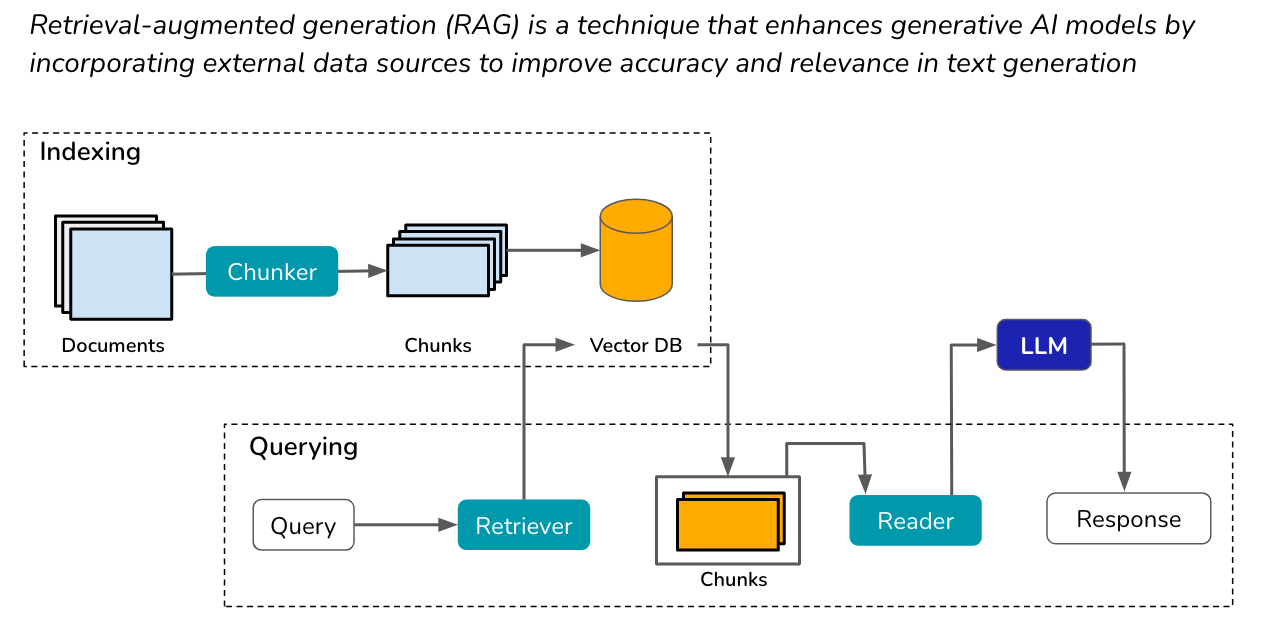

**Indexing**

In the first step, we ingest the different sources of data into a document database. At this stage, the focus is on assembling all the data (irrespective of format, e.g., text, pdf) relevant to the use case and data exists in the raw unmodified form. However, given context window limitations of LLMs, we cannot stuff all the documents in the database as context. Even if we did have an infinite context window, the LLM would find it difficult to provide a coherent answer while sifting through the noise for the signal. To avoid this situation, we will need to carefully select documents that relate to the user input so the LLM can be tasked to answer based only on the context.

A key method to aid retrieval of relevant documents is to convert the ingested raw data into a vector representation. This way, we can compare the query (converted into a vector) with the document vectors and choose only those documents that are similar to the query. This process of creating a vector representation from input text is called embedding and is achieved using embedding models (for e.g., SentenceTransformer). Once embeddings are created they can be stored for efficient retrieval in specialized vector data stores such as Pinecone or ChromaDB (we use ChromaDB in this notebook).


While embeddings solve for retrieval of appropriate context given a query, a more efficient application of vectorization is to transform raw data into smaller chunks before feeding it to an embedding model. There are two important reasons why this is needed:

- Embedding models are themselves Transformer models and hence have input length constraints. Any text that is longer than the maximum input length allowed by the embedding model is usually truncated.
- Slicing the data into chunks facilitates fine-grained control on the specific information that can be injected as context. This helps the model focus only on the information most relevant to the query.

**Retrieval**

In the second step, a prompt is dynamically assembled when a user input is received. This user input is converted to a vector representation using the same model that was used for the context chunks. Then a similary search is executed against the vectorized chunks in the vector database. Top-$k$ chunks from the search results in this step are then stuffed into the prompt as the context and the LLM is instructed to answer the user query using only the context.

To facilitate indexing and retrieval, abstractions such a chunkers, retrievers and readers are used that interface with the document database, vector database and the LLM respectively. Popular packages that implement these abstractions are `langchain` and `llamaindex`.

Now that we have an overview of the process, let us take a deeper look at each of these steps.

## Step 1: Creating a Vector Database (Indexing)

We create a vector database by chunking the input document and then associating each chunk with a vector using an embedding model. The overall process is described in the figure below.

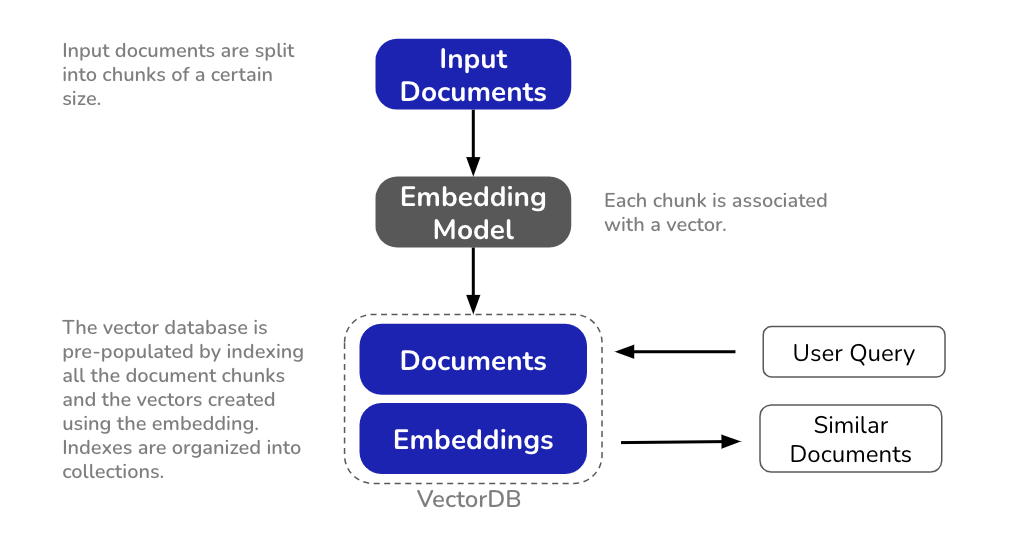

As the above figure indicates, there are two important components of vector database creation that merit a deeper look - choice of embedding model and chunking.

### Choosing an embedding model

Let us first recap what embeddings are:

- Embeddings are a type of word representation that allows words with similar meaning to have a similar representation.
- They capture semantic properties of words and relations with other words.


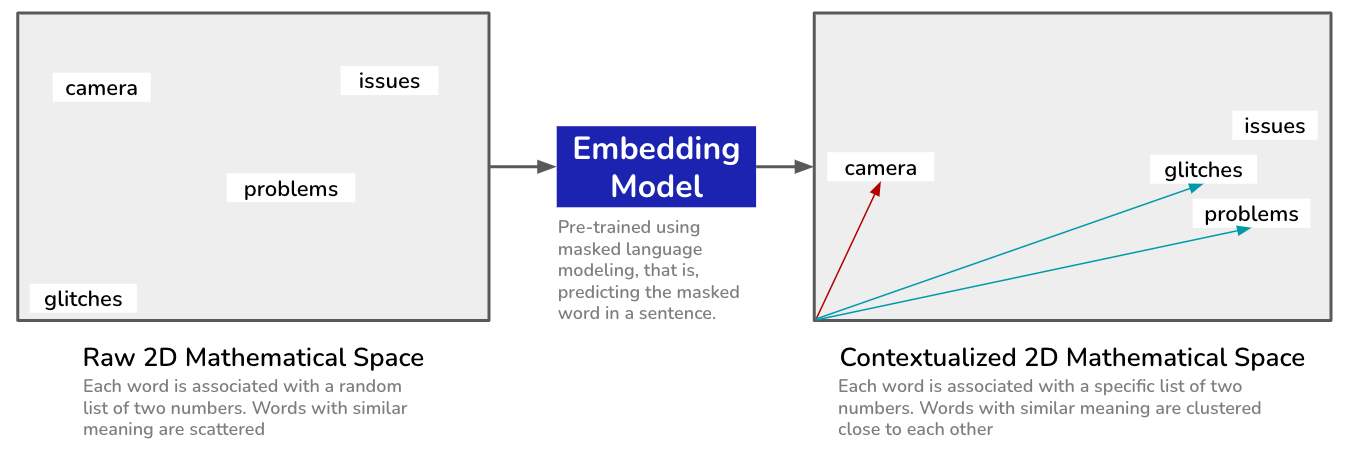

Similar to word embedding models, sentence embedding models represent the meaning of whole sentences. They are derived by averaging word embeddings or using specialized embedding models.

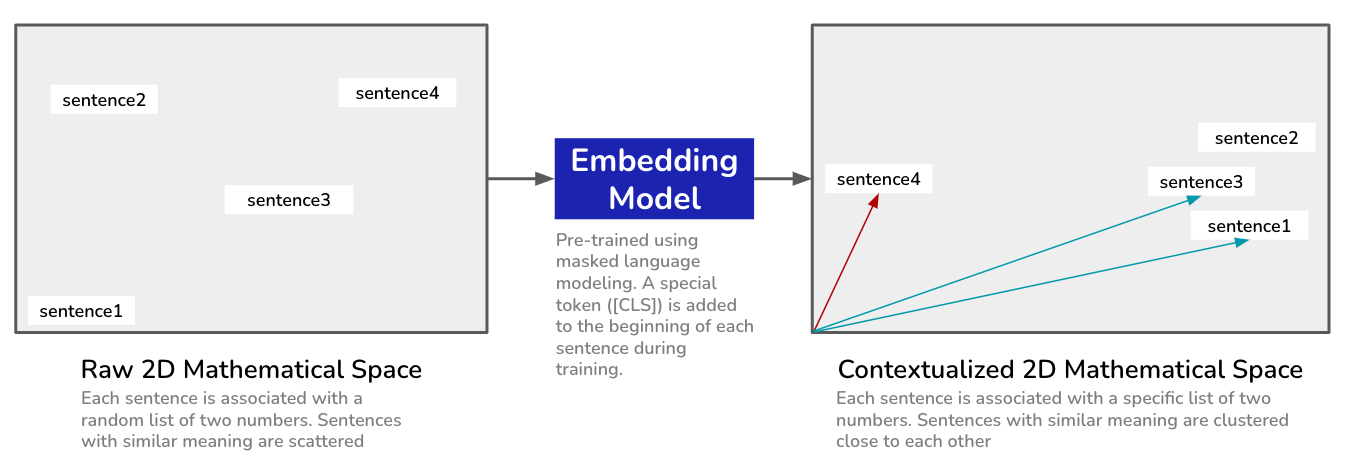

Good embedding models encode text into vector representations that act as good features for the downstream LLM tasks (for e.g., in this case, retrieval). However, there are many embedding models to choose from (both free and paid) and the choice is not often not straight forward. Moreover, there is no evidence that free/open-source embedding models (for e.g., models hosted on HuggingFace) are less effective compared to paid models (for e.g., from Open AI).

A good method to choose an embedding model, is to use the [embedding leaderboard](https://huggingface.co/spaces/mteb/leaderboard) and select an open source model that is performant for the use case at hand.

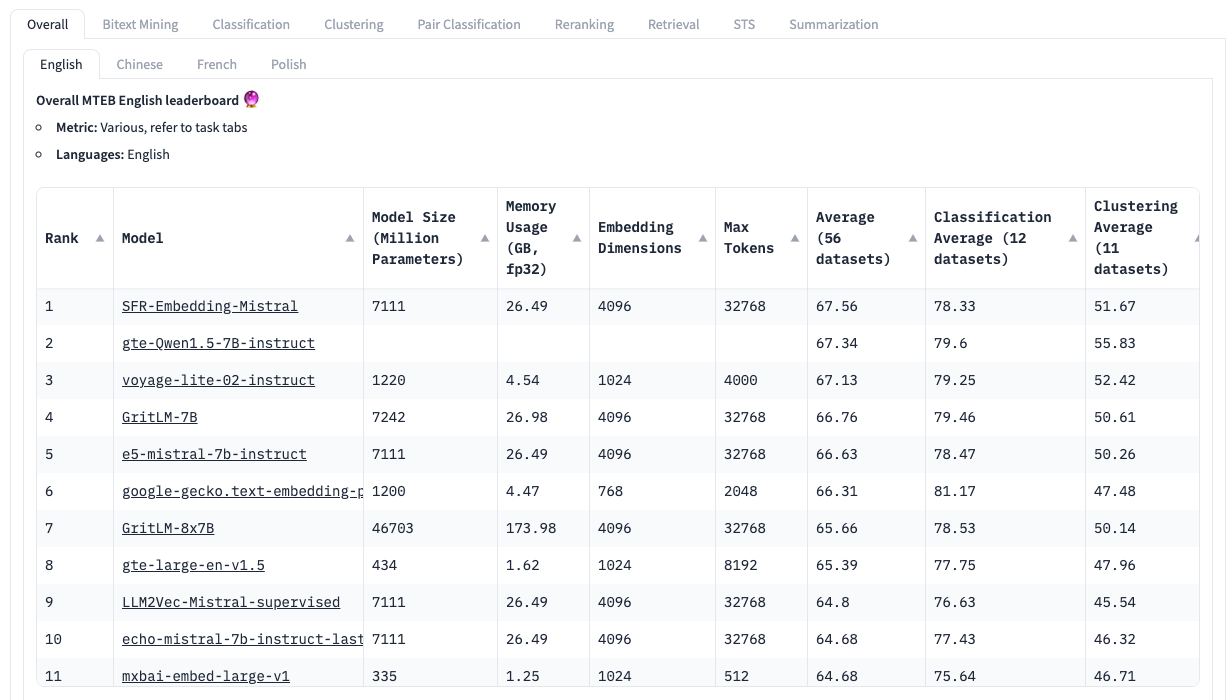

A good general purpose embedding model is [`gte-large`](https://huggingface.co/thenlper/gte-large).

### Chunking documents

Once the choice of embedding model is made, we can feed the input documents to the model. However, since there are multiple pages across documents (including figures, tables) we will need a method to parse individual portions of the document that is aligned with the embedding model.

We also know that the embedding model cannot process text beyond a fixed context length (512 tokens for `gte-large`). This roughly corresponds to about 400 words or about 1 page of text. With this limitation in mind, we will transform the pdf file into chunks of text that are no more than 512 chunks long. An alternative method would be to chunk the file by sections in the report (e.g., risk factors, legal proceedings, safety disclosures).

A common chunking strategy is to used a fixed-size chunk as defined by the embedding model and use a small overlap between the chunks (see figure below).


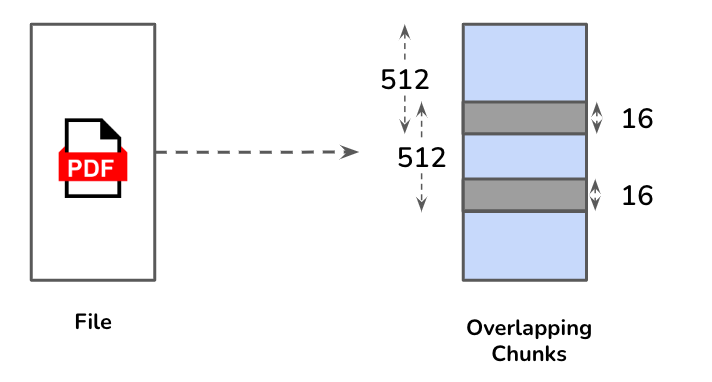

Using an overlap allows for continuity between chunks and retrieval of relevant chunks even when the information relevant to the query is present either at the beginning of the chunk or the end of the chunk.

### Creating a persistent vector database

With an embedding model and chunking strategy in place, we can set up an information processing pipeline, where each document is parsed into a Python runtime, chunked and passed to the embedding model. The document chunk and embedding is then stored as an entry in the vector database.

Note that the vector databases themselves are full fledged databases. They support the entire gamut of Create, Read, Update and Delete (CRUD) operations. In this notebook, we will use `langchain` abstractions to chunk and create a persistent database. Refer to the [Chroma DB documentation](https://docs.trychroma.com/api-reference) for an overview on CRUD operations.

## Step 2: Querying the Vector Database

Once the vector database is set up, embedding generated from the query text is compared with all the document embeddings in the vector database. The most similar documents are then retrieved and presented along with the original query in the prompt.

Finally, in the prompt, we instruct the LLM to focus only on the context to answer the user query. The key idea here is that both the query and the context are both dynamically injected into the prompt.

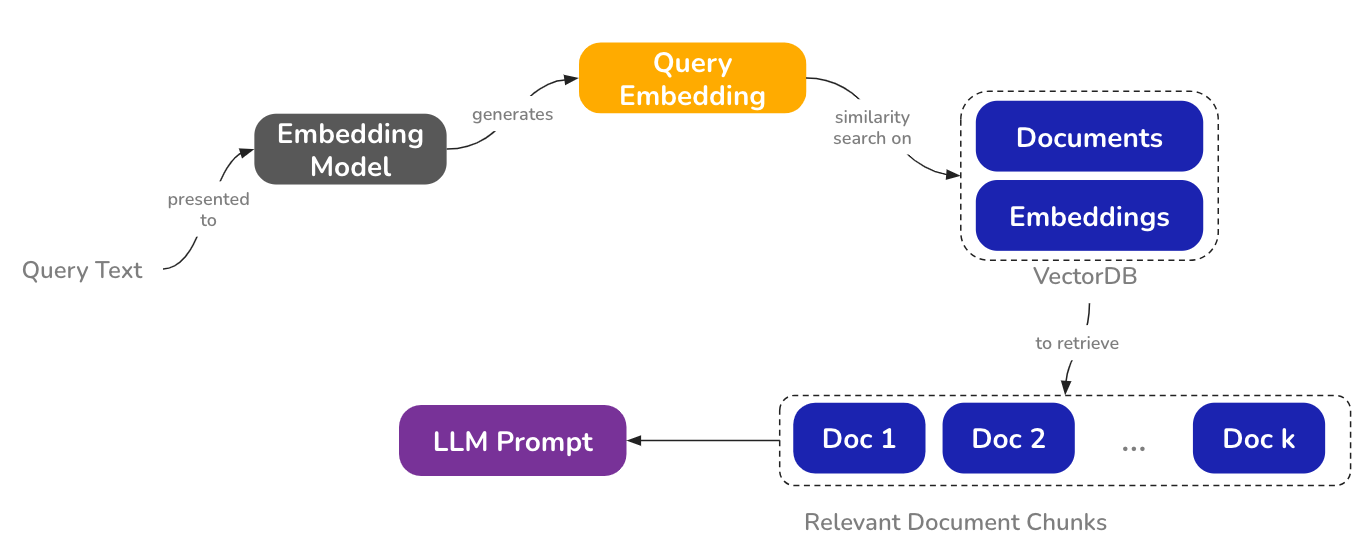

## Evaluation

Since RAG is a special case of text-to-text generation, evaluation is no different from what we saw before. We either use human baselines or use LLM-as-a-judge to evaluate RAG workflows.

However, since RAG systems have two compponents (indexing and retrieval), they are usually judged on [two important parameters](https://docs.ragas.io/en/stable/concepts/metrics/index.html#ragas-metrics):
- Groundedness/Faithfulness: How factually accurate the answer is given the context?
- Relevance: How relevant is the context retrieved given the query?

These two metrics check the quality two components of the RAG system - retrieval and generation. To evaluate these components individually, it is common to use LLM-as-a-judge method to check the quality of the RAG system. We write two prompts corresponding to each of these metrics and using the user input, context and answer, evaluate the performance of the RAG system.

Unlike evaluation of classification and summarization, it is critical to create a pool of gold examples that reflect the user intent.

## RAG Q&A

### Prompt Design

In [76]:
qna_system_message = """
You are an assistant to a financial services firm who answers user queries on annual reports.
User input will have the context required by you to answer user questions.
This context will begin with the token: ###Context.
The context contains references to specific portions of a document relevant to the user query.

User questions will begin with the token: ###Question.

Please answer only using the context provided in the input. Do not mention anything about the context in your final answer.

If the answer is not found in the context, respond "I don't know".
"""

In [77]:
qna_user_message_template = """
###Context
Here are some documents that are relevant to the question mentioned below.
{context}

###Question
{question}
"""

### Composing the response

In [78]:
context_for_query = """
In 2020, we recognized total revenues of $31.54 billion, representing an increase of $6.96 billion compared to the prior year. We continue to ramp
production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue
growth.
In 2020, our net income attributable to common stockholders was $721 million, representing a favorable change of $1.58 billion compared to the prior
year. In 2020, our operating margin was 6.3%, representing a favorable change of 6.6% compared to the prior year. We continue to focus on operational
efficiencies, while we have seen an acceleration of non-cash stock-based compensation expense due to a rapid increase in our market capitalization and updates
to our business outlook.
We ended 2020 with $19.38 billion in cash and cash equivalents, representing an increase of $13.12 billion from the end of 2019. Our cash flows from
operating activities during 2020 was $5.94 billion, compared to $2.41 billion during 2019, and capital expenditures amounted to $3.16 billion during 2020,
compared to $1.33 billion during 2019. Sustained growth has allowed our business to generally fund itself, but we will continue a number of capital-intensive
projects in upcoming periods.
"""

In [79]:
user_input = "What was the annual revenue of the company in 2020?"

In [80]:
prompt = [
    {'role':'system', 'content': qna_system_message},
    {'role': 'user', 'content': qna_user_message_template.format(
         context=context_for_query,
         question=user_input
        )
    }
]

try:
    response = client.chat_completion(
        messages=prompt,
        temperature=0.2,
        max_tokens=1024
    )

    prediction = response.choices[0].message.content.strip()
except Exception as e:
    prediction = f'Sorry, I encountered the following error: \n {e}'

print(prediction)

The annual revenue of the company in 2020 was $31.54 billion.


## Evaluation

Let us now use the LLM-as-a-judge method to check the quality of the RAG system on two parameters - retrieval and generation. We illustrate this evaluation based on the answeres generated to the question from the previous section.

In [81]:
groundedness_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
The answer should be derived only from the information presented in the context

Instructions:
1. First write down the steps that are needed to evaluate the answer as per the metric.
2. Give a step-by-step explanation if the answer adheres to the metric considering the question and context as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the answer using the evaluaton criteria and assign a score.
"""

In [82]:
relevance_rater_system_message = """
You are tasked with rating relevance of context retrieved with an intent to answer questions posed by users.
You will be presented a question, and context retrieved to answer the question.
In the input, the question will begin with ###Question, and the context will begin with ###Context.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
All the information in the context should be relevant to the question.

Instructions:
1. First write down the steps that are needed to evaluate the context as per the metric.
2. Give a step-by-step explanation if the context adheres to the metric considering the question as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the context using the evaluaton criteria and assign a score.
"""

In [83]:
groundedness_user_message_template = """
###Question
{question}

###Context
{context}

###Answer
{answer}
"""

In [84]:
relevance_user_message_template = """
###Question
{question}

###Context
{context}
"""

In [85]:
print(prediction)

The annual revenue of the company in 2020 was $31.54 billion.


In [86]:
groundedness_prompt = [
    {'role':'system', 'content': groundedness_rater_system_message},
    {'role': 'user', 'content': groundedness_user_message_template.format(
        question=user_input,
        context=context_for_query,
        answer=prediction
        )
    }
]

In [87]:
response = client.chat_completion(
        messages=groundedness_prompt,
        temperature=0.2,
        max_tokens=1024
)

print(response.choices[0].message.content)

Steps to evaluate the answer:
1. Identify the question asked by the user.
2. Identify the information provided in the context that could potentially answer the question.
3. Compare the user's question with the information found in the context to determine if the answer provided is derived only from the information presented in the context.

Explanation:
The user's question asks for the annual revenue of the company in 2020. The context provides the exact figure for the annual revenue in 2020, which is $31.54 billion. The answer provided, "The annual revenue of the company in 2020 was $31.54 billion," is a direct quote from the context and is derived only from the information presented in the context.

Evaluation:
The metric is followed completely.

Rating:
5 (The metric is followed completely)


In [88]:
relevance_prompt = [
    {'role':'system', 'content': relevance_rater_system_message},
    {'role': 'user', 'content': relevance_user_message_template.format(
        question=user_input,
        context=context_for_query
        )
    }
]

In [89]:
response = client.chat_completion(
        messages=relevance_prompt,
        temperature=0.2,
        max_tokens=1024
)

print(response.choices[0].message.content)

Steps to evaluate the context as per the metric:
1. Identify the question posed by the user.
2. Search for specific information related to the question in the context.
3. Verify if the identified information is relevant to the question.
4. Check if all the information in the context is relevant to the question.

Explanation:
1. The question posed by the user is "What was the annual revenue of the company in 2020?"
2. In the context, the specific information related to the question can be found where it mentions "In 2020, we recognized total revenues of $31.54 billion."
3. This identified information is relevant to the question as it provides the annual revenue of the company in 2020.
4. Upon checking, it can be seen that all the information in the context is not relevant to the question, as the rest of the context discusses other financial metrics such as net income, operating margin, cash and cash equivalents, cash flows from operating activities, capital expenditures, and future plan